In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
IMG_SHAPE = (IMG_W, IMG_H, CHANNELS)
INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25

BATCH_SIZE = 64

### Spliting The Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading The Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing The Dataset

In [0]:
def read_ds(ds="train", max_frames_per_video=0, separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  i=0
  X_per_video = []
  y_per_video = []
  print("total videos : %s" % len(videos))

  for video in videos: 

    if(max_frames_per_video == 0):

        for frame in video["frames"]:
            X.append(frame.reshape(IMG_SHAPE))
            y.append(CATEGORIES.index(video["category"]))
  
        if(separate_each_video):
            X_per_video.append(np.array(X, dtype=np.float32))
            y_per_video.append(np.array(y, dtype=np.uint8))
            X = []
            y = []  
        
    elif(max_frames_per_video == 1):

        index = np.random.choice(len(video["frames"]))
        frame_data = video["frames"][index]
  
        X.append(frame_data.reshape(IMG_SHAPE))
        y.append(CATEGORIES.index(video["category"]))

    else:

        skip = (len(video["frames"]) // max_frames_per_video)

        for i in range(0, len(video["frames"]), skip):
          X.append(np.array(video["frames"][i].reshape(IMG_SHAPE), dtype=np.float32))
        
        y.append(np.array(CATEGORIES.index(video["category"]), dtype=np.uint8))
        
        
        X = X[:max_frames_per_video]
        
        X_per_video.append(np.array(X, dtype=np.float32))
        y_per_video.append(np.array(y, dtype=np.uint8))

        X = []
        y = []  
      

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)


  if (max_frames_per_video == 0):
    if(separate_each_video):
      #for x in X_per_video:
        #mean = np.mean(x)
        #x -= float(mean)
      return np.array(X_per_video), np.array(y_per_video)
    
    #mean = np.mean(X)
    #X -= float(mean)
    
    return X, y

  elif (max_frames_per_video == 1):
    #mean = np.mean(X)
    #X -= float(mean)

    return X, y
  

  else: # (max_frames_per_video > 1):
    #for x in X_per_video:
      #mean = np.mean(x)
      #x -= float(mean)
      
    return np.array(X_per_video), np.array(y_per_video)

In [0]:
def generate_sequences(ds="train", separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  X_per_video = []
  y_per_video = []
  
  for video in videos:

    frames = video["frames"]
    sequences = len(frames) // SEQ_LEN
    seq_frames = []
    sequnces_frames = [] 
    step = SEQ_LEN
    for i in range(0, len(frames)):
      if(i < step):
        seq_frames.append(frames[i])
      else:
        sequnces_frames.append(seq_frames)
        seq_frames = []
        step = step + SEQ_LEN + 1
    sequnces_frames = np.array(sequnces_frames[:sequences])
    for seq in sequnces_frames:
      X.append(seq.reshape(INPUT_SHAPE))
      y.append(CATEGORIES.index(video["category"]))

    if(separate_each_video):
      if(len(X_per_video) == 0) :
        X_per_video.append(np.array(X))      
        y_per_video.append(np.array(y))      
      else: 
        X_per_video.append(np.array(X))
        y_per_video.append(np.array(y))
        #y_per_video = cat((y_per_video, np.array(y)), axis=0)

      X = []
      y = []  


  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  if(separate_each_video):
    return np.array(X_per_video), np.array(y_per_video)

  return X, y

In [8]:
X_test_average_prediction, y_test_average_prediction = generate_sequences( ds="test", separate_each_video=True)
X_test_average_prediction.shape, y_test_average_prediction.shape

((216,), (216,))

In [9]:
X_test_average_prediction[0].shape, y_test_average_prediction[0].shape 

((13, 30, 60, 80, 1), (13,))

In [0]:
# X_train, y_train = read_ds(ds="train", max_frames_per_video=SEQ_LEN)
# X_dev, y_dev = read_ds(ds="dev", max_frames_per_video=SEQ_LEN)
# X_test, y_test = read_ds(ds="test", max_frames_per_video=SEQ_LEN)


X_train, y_train = generate_sequences(ds="train")
X_dev, y_dev = generate_sequences(ds="dev")
X_test, y_test = generate_sequences(ds="test")

In [11]:
X_test_average_prediction.shape, y_test_average_prediction.shape

((216,), (216,))

In [12]:
X_train.shape, y_train.shape 

((2316, 30, 60, 80, 1), (2316,))

In [13]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

##Preparing The Model (LRCN - VGG16 Style)

In [16]:
# CNN model (VGG-like)
model = Sequential()
weights_init = 'glorot_uniform'
## Stage 1
model.add(TimeDistributed(Conv2D(32, (3, 3), kernel_initializer=weights_init), input_shape=INPUT_SHAPE))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Stage 2
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Stage 3
model.add(TimeDistributed(Conv2D(128,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(128,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Output
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(256,activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(512,activation='relu')))
model.add(Dropout(0.5))
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(2048, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 58, 78, 32)    320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 78, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 56, 76, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 56, 76, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 28, 38, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 26, 36, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 26, 36, 64)   

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Training The Model

In [19]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2316 samples, validate on 2256 samples
Epoch 1/25
2316/2316 [==============================] - 48s 21ms/step - loss: 1.5434 - acc: 0.3873 - val_loss: 1.1613 - val_acc: 0.4951
Epoch 2/25
2316/2316 [==============================] - 34s 15ms/step - loss: 0.8072 - acc: 0.6248 - val_loss: 1.1424 - val_acc: 0.6383
Epoch 3/25
2316/2316 [==============================] - 34s 15ms/step - loss: 0.6518 - acc: 0.7060 - val_loss: 1.1900 - val_acc: 0.6285
Epoch 4/25
2316/2316 [==============================] - 34s 15ms/step - loss: 0.5645 - acc: 0.7457 - val_loss: 1.1052 - val_acc: 0.6485
Epoch 5/25
2316/2316 [==============================] - 34s 15ms/step - loss: 0.5376 - acc: 0.7582 - val_loss: 2.3151 - val_acc: 0.4836
Epoch 6/25
2316/2316 [==============================] - 34s 15ms/step - loss: 0.4866 - acc: 0.7725 - val_loss: 0.9233 - val_acc: 0.7048
Epoch 7/25
2316/2316 [==================

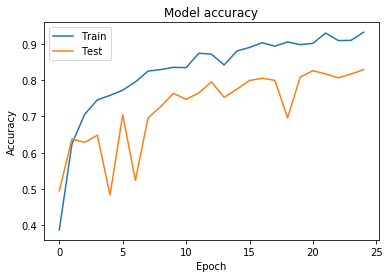

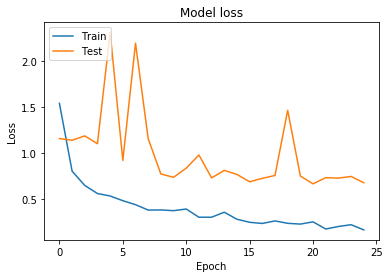

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Evaluating The Model
### 1) Simple Evaluation 
#### 1.1 Evaluating this training attemp


In [21]:
model.evaluate(X_test, y_test)

2450/2450 [==============================] - 11s 5ms/step


[1.1250547936774566, 0.7640816326530612]

### 2) Average Prediction Evaluation

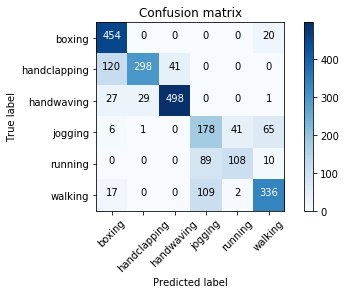

In [22]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
preds = np.array([])
pred_y = []
i = 0
for video_seq_frames in X_test_average_prediction:
  
  y_per_vid = np.array([])

  if(len(video_seq_frames.shape) == len(INPUT_SHAPE)): # if the video contains only 1 sequence
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(np.expand_dims(video_seq_frames, axis=0))
    
  else:
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(video_seq_frames)

  results = np.array(p).mean(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)

  #preds = cat((preds, p))
  preds = np.append(preds, p)

  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [24]:
y_test_per_video_classes = []
_, y_test_per_video = read_ds(ds="test", max_frames_per_video=1)
y_test_per_video = to_categorical(y_test_per_video)

for y in y_test_per_video:
  index = np.argmax(y)
  label = CATEGORIES[index]
  y_test_per_video_classes.append(index)
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

total videos : 216


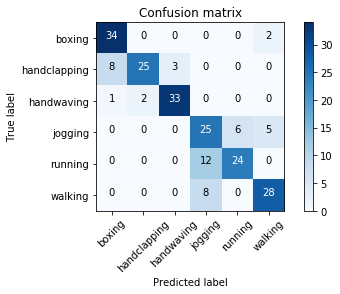

In [25]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [26]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1

accuracy = acc / len(pred_y)
print("Average Prediction Accuracy : %s" % accuracy)

Average Prediction Accuracy : 0.7824074074074074


### 3) Max Prediction Evaluation

In [0]:
preds = np.array([])
pred_y = []
i = 0
for video_seq_frames in X_test_average_prediction:
  
  y_per_vid = np.array([])

  if(len(video_seq_frames.shape) == len(INPUT_SHAPE)): # if the video contains only 1 sequence
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(np.expand_dims(video_seq_frames, axis=0))
    
  else:
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(video_seq_frames)

  results = np.array(p).max(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)

  #preds = cat((preds, p))
  preds = np.append(preds, p)

  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [28]:
y_test_per_video_classes = []
_, y_test_per_video = read_ds(ds="test", max_frames_per_video=1)
y_test_per_video = to_categorical(y_test_per_video)

for y in y_test_per_video:
  index = np.argmax(y)
  label = CATEGORIES[index]
  y_test_per_video_classes.append(index)
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

total videos : 216


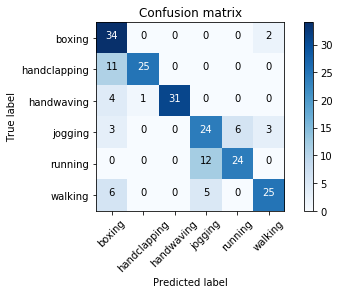

In [29]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [30]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1

accuracy = acc / len(pred_y)
print("Max Prediction Accuracy : %s" % accuracy)

Max Prediction Accuracy : 0.7546296296296297


##Saving The Model 

In [0]:
model.save_weights('LRCN_KTH.h5')

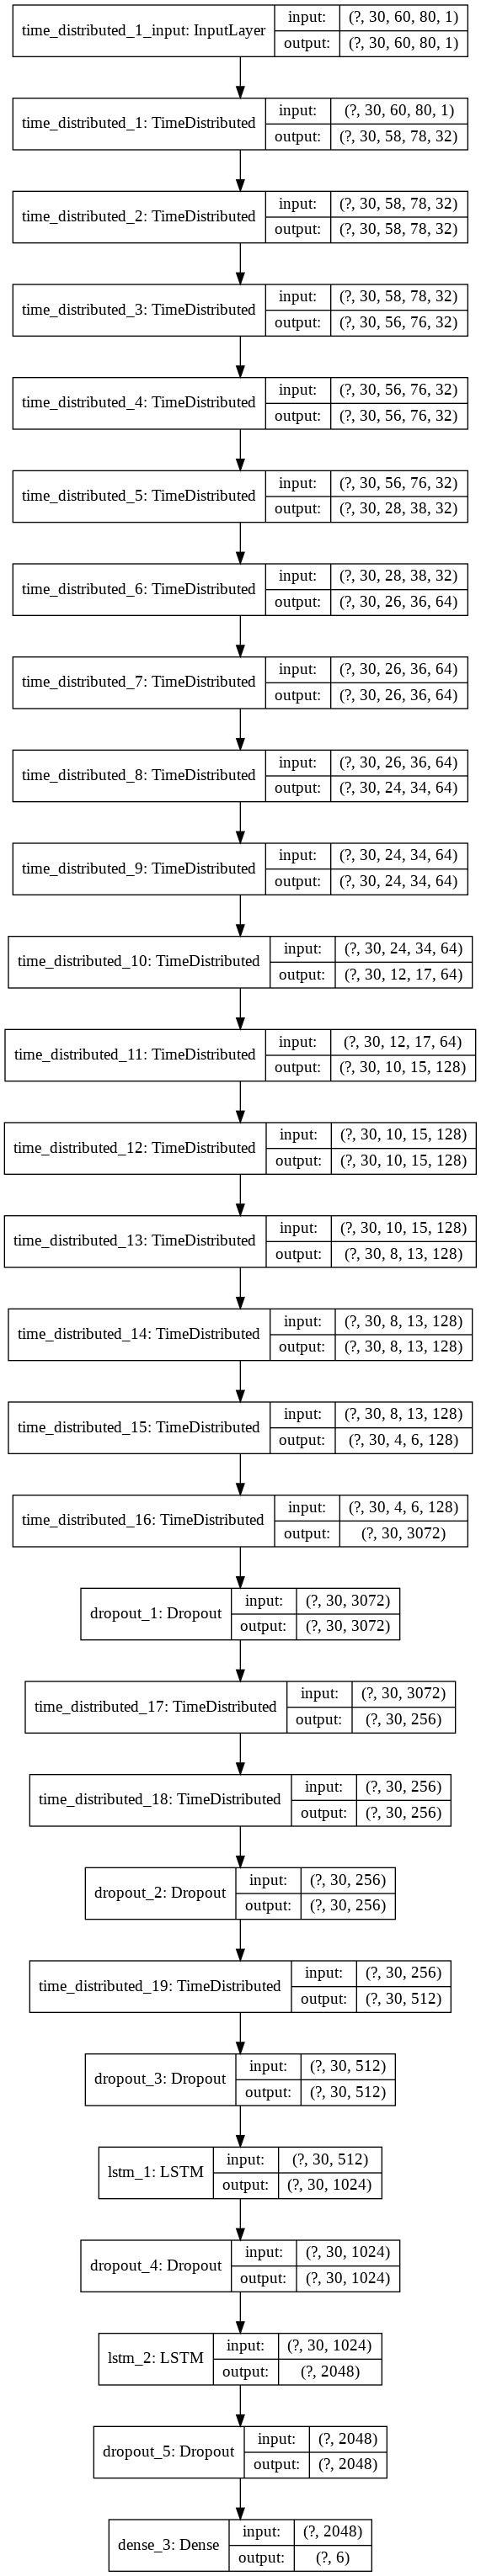

In [32]:
plot_model(model, show_shapes=True, to_file='LRCN_KTH.png')